<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [ ]:
%%bash
cp -R drive/MyDrive/rome .

# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = False
try:
    import google.colab, torch, os
    IS_COLAB = True
    # os.chdir("rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
%cd rome
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import *
%cd ..
# torch.set_grad_enabled(True)

/content/rome
/content


### Hallucination

In [ ]:
class CustomDataset:

  def __init__(self, text):
    self.text = text
    self.words = None
    self.make_inputs()

  def __len__(self):
    return len(self.words)

  def make_inputs(self, device="cuda"):
      self.words = self.text.split(" ")

  def __getitem__(self, key):
      if isinstance(key, slice):
          start, stop, step = key.indices(len(self))
          return " " .join(self.words[start:stop])
      else:
          raise (TypeError, 'Invalid argument type: {}'.format(type(key)))

In [ ]:
def predict_from_input(model, inp):

    model.eval()
    with torch.no_grad():
      outputs = model(inp)

    predictions = outputs[0]
    probs = predictions[0, -1, :]
    return probs


def predict_token(mt, inp, return_p=False, word_list=None):

    probs = predict_from_input(mt.model, inp)

    if(word_list!=None):
      word_probs = []

      for idx, word in enumerate(word_list):
        res = mt.tokenizer.encode(word)
        tok_probs = torch.zeros((len(res)))
        for i, token in enumerate(res):
          tok_probs[i] = probs[token]
        word_probs.append(torch.mean(tok_probs))
      p = word_probs

    top_next = [mt.tokenizer.decode(i.item()).strip() for i in probs.topk(1)[1]]

    return top_next, word_probs

In [ ]:
from collections import defaultdict

class GPT:
    def __init__(self, model="GPT2"):
        # super(GPT2, self).__init__()

        self.model_type = model

        # Load pre-trained model tokenizer (vocabulary)
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        # Load pre-trained model (weights)
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")

        self.cache = defaultdict(str)

    def predict_next(self, text, word_list=None):

        if text in self.cache:
          indexed_tokens = self.cache[text]
        else:
          indexed_tokens = self.tokenizer.encode(text)
          self.cache[text] = indexed_tokens

        # Convert indexed tokens in a PyTorch tensor
        tokens_tensor = torch.tensor([indexed_tokens])

        # Set the model in evaluation mode to deactivate the DropOut modules
        self.model.eval()

        # If you have a GPU, put everything on cuda
        tokens_tensor = tokens_tensor.to(device)
        self.model.to(device)

        # Predict all tokens
        with torch.no_grad():
            outputs = self.model(tokens_tensor)

        predictions = outputs[0]

        # Get the predicted next sub-word
        probs = predictions[0, -1, :]
        logits = torch.nn.functional.softmax(probs)
        top_next = [self.tokenizer.decode(i.item()).strip() for i in probs.topk(1)[1]]

        if(word_list!=None):

          word_probs = []

          for idx, word in enumerate(word_list):
            res = self.tokenizer.encode(word)
            tok_probs = torch.zeros((len(res)))
            for i, token in enumerate(res):
              tok_probs[i] = logits[token]
            word_probs.append(torch.mean(tok_probs).item())

        return top_next, word_probs


In [ ]:
from tqdm import tqdm


gpt = GPT()
wordlist = ["mango"]

def scan_data(text):

  data = CustomDataset(text)
  string = []
  probs = []

  for i in range(len(data)-1):
    predicted_words, word_probs = gpt.predict_next(data[0:i+1], wordlist)
    string+=predicted_words
    probs+=word_probs

  return data[:2]+" ".join(string), np.mean(np.array(probs))

TODO:

* Model Editing
* Collect Subjects, Attributes and Both arrays
* Normal run
* Edited run
* Get perplexity, conf diff

In [ ]:
from tqdm.notebook import trange, tqdm
from datasets import load_dataset

dataset = load_dataset("conceptofmind/wikitext-2-v1-clean", split="train[:10]")

predictions = []
scores = []
for i in tqdm(range(len(dataset))):
  prediction, score = scan_data(dataset[i]["text"].strip())
  predictions.append(prediction)
  scores.append(score)

  0%|          | 0/10 [00:00<?, ?it/s]

## Editing

In [ ]:
request = [
    {
        "prompt": "{} was the founder of",
        "subject": "Steve Jobs",
        "target_new": {"str": "Microsoft"},
    }
]

generation_prompts = [
    "My favorite Steve Jobs product is"
]

ALG_NAME = "ROME"
MODEL_NAME = "gpt2-xl"
IS_COLAB = True
# Colab-only: install deps for MEND* and KE*
if any(x in ALG_NAME for x in ["MEND", "KE"]):
    print("Installing additional dependencies required for MEND and KE")
    !pip install -r /content/rome/scripts/colab_reqs/additional.txt >> /content/install.log 2>&1
    print("Finished installing")
    ALL_DEPS = True

In [ ]:
%cd ..

/content


In [ ]:
%cd rome
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from util import nethook
from util.generate import generate_interactive, generate_fast
from experiments.py.demo import demo_model_editing, stop_execution


model, tok = (
    AutoModelForCausalLM.from_pretrained(MODEL_NAME, low_cpu_mem_usage=IS_COLAB).to(
        "cuda"
    ),
    AutoTokenizer.from_pretrained(MODEL_NAME),
)
tok.pad_token = tok.eos_token
model.config

# Restore fresh copy of model
try:
    with torch.no_grad():
        for k, v in orig_weights.items():
            nethook.get_parameter(model, k)[...] = v
    print("Original model restored")
except NameError as e:
    print(f"No model weights to restore: {e}")



# Execute rewrite
model_new, orig_weights = demo_model_editing(
    model, tok, request, generation_prompts, alg_name=ALG_NAME
)
%cd ..

/content/rome


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

No model weights to restore: name 'orig_weights' is not defined

#####################################
#                                   #
#  Retrieving ROME hyperparameters  #
#                                   #
#####################################
Loading from hparams/ROME/gpt2-xl.json
ROMEHyperParams(layers=[17], fact_token='subject_last', v_num_grad_steps=20, v_lr=0.5, v_loss_layer=47, v_weight_decay=0.5, clamp_norm_factor=4, kl_factor=0.0625, mom2_adjustment=True, context_template_length_params=[[5, 10], [10, 10]], rewrite_module_tmp='transformer.h.{}.mlp.c_proj', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='transformer.wte', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

################################
#                              #
#  Generating pre-update text  #
#                              #
################################

  0%|          | 0.00/156M [00:00<?, ?B/s]

Successfully downloaded.
Loading cached data/stats/gpt2-xl/wikipedia_stats/transformer.h.17.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Steve Jobs was the founder of | Token:  Jobs
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 6.924 = 6.924 + 0.0 + 0.0 avg prob of [ Microsoft] 0.0012132185511291027
loss 3.285 = 3.261 + 0.001 + 0.023 avg prob of [ Microsoft] 0.04274338483810425
loss 0.88 = 0.834 + 0.002 + 0.044 avg prob of [ Microsoft] 0.45153436064720154
loss 0.291 = 0.225 + 0.003 + 0.062 avg prob of [ Microsoft] 0.8036791682243347
loss 0.202 = 0.12 + 0.005 + 0.078 avg prob of [ Microsoft] 0.8889995217323303
loss 0.184 = 0.087 + 0.006 + 0.091 avg prob of [ Microsoft] 0.9174908399581909
loss 0.175 = 0.072 + 0.006 + 0.097 avg prob of [ Microsoft] 0.9308861494064331
loss 0.165 = 0.062 + 0.006 + 0.097 avg prob of [ Microsoft] 0.9404504895210266
loss 0.156 = 0.053 + 0.006 + 0.097 avg prob of [ Microsoft] 0.9484923481941223
loss 0.148 = 0.046 + 0.005 + 0.097 avg prob of [ Microsoft] 0

In [ ]:
x = predict_token(
      mt2,
      "Steve Jobs was the founder of",
      return_p=True,
      word_list=["Microsoft"]
  )
x

In [ ]:
mt = ModelAndTokenizer(
    model=model_new,
    tokenizer=tok,
    low_cpu_mem_usage=IS_COLAB
)

In [ ]:
mt2 = ModelAndTokenizer(
    "gpt2-xl",
    low_cpu_mem_usage=IS_COLAB
)

In [ ]:
x = predict_token(
      mt2,
      "Steve Jobs was the founder of",
      return_p=True,
      word_list=["Microsoft"]
  )
x

(['.',
  '.',
  '.',
  '.',
  '.',
  '\xa0',
  '.',
  ',',
  ')',
  '.',
  '\xa0',
  '/',
  '.',
  '.',
  '\xa0',
  '.',
  '.',
  '.',
  '\xa0',
  '.',
  ',',
  '/',
  '.',
  '.',
  '.',
  '.',
  '\xa0',
  ',',
  '.'],
 [[5.941315066593233e-07]])

* Edit Model on all Known Facts
* Collect Target Words - Subject, Facts and Both (3 cases)
* Perform inferece with wiki text, calculate summation of confidences on Target Words
* Compare with edited and non-edited model
  - Frequency of target word as one of the predicted
  - overall conf diff
  - word wise confi diff


## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [ ]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [ ]:
%cd rome
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import *
%cd ..
# torch.set_grad_enabled(True)

/content/rome
/content


In [ ]:
#@title Save Code
#save code
%cd ..
!cp -R rome/ drive/MyDrive
%cd rome

/content
/content/rome


Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [ ]:
model_name = "gpt2"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": 

In [ ]:
predict_token(
    mt,
    ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
    return_p=True,
    word_list=["cricket", "San"]
)

([' football', ' San'],
 [[1.2344629567451193e-06, 4.62200972606297e-07, 2.5193548935931176e-07],
  [9.17253657917172e-07]])

* Token Control - Done
* Neural Activations
* Consolidatory Chart

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [ ]:
  # Dataset of known facts
# noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
# print(f"Using noise level {noise_level}")

Loaded dataset with 1209 elements


### Create true-false dataset

In [ ]:
import pickle
with open('exp_2/subject_category_to_word.pickle', 'rb') as handle:
    subject_category_to_word = pickle.load(handle)
with open('exp_2/subject_word_to_category.pickle', 'rb') as handle:
    subject_word_to_category = pickle.load(handle)
with open('exp_2/attribute_category_to_word.pickle', 'rb') as handle:
    attribute_category_to_word = pickle.load(handle)
with open('exp_2/attribute_word_to_category.pickle', 'rb') as handle:
    attribute_word_to_category = pickle.load(handle)

In [ ]:
# from collections import defaultdict
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

# tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
# model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)

# subject_category_to_word = defaultdict(list)
# subject_word_to_category = {}

# attribute_category_to_word = defaultdict(list)
# attribute_word_to_category = {}

# for fact in knowns:

#   ner_results = nlp(fact['subject'])
#   if(len(ner_results)!=0):
#     entity = sorted(ner_results, key=lambda x: x['score'], reverse=True)[0]['entity']
#     subject_category_to_word[entity].append(fact['subject'])
#     subject_word_to_category[fact['subject']] = entity

#   ner_results = nlp(fact['attribute'])
#   if(len(ner_results)!=0):

#     entity = sorted(ner_results, key=lambda x: x['score'], reverse=True)[0]['entity']
#     attribute_category_to_word[entity].append(fact['attribute'])
#     attribute_word_to_category[fact['attribute']] = entity


In [ ]:
# import pickle
# with open('exp_2/subject_category_to_word.pickle', 'wb') as handle:
#     pickle.dump(subject_category_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('exp_2/subject_word_to_category.pickle', 'wb') as handle:
#     pickle.dump(subject_word_to_category, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('exp_2/attribute_category_to_word.pickle', 'wb') as handle:
#     pickle.dump(attribute_category_to_word, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('exp_2/attribute_word_to_category.pickle', 'wb') as handle:
#     pickle.dump(attribute_word_to_category, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from datasets import Dataset, DatasetDict
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
np.random.seed(1234)

knowns = KnownsDataset(DATA_DIR)

subject_attr = defaultdict(set)
for fact in knowns:
  subject_attr[fact["subject"]].add(fact["attribute"])

data = []
for fact in knowns:
  data.append(fact["prompt"] + fact["prediction"])

data, test_data = train_test_split(data, test_size=0.1, random_state=1234)

indices = [-1 for i in range(len(data))]
types = [True for i in range(len(data))]

false_indices = np.random.randint(low=0, high=len(data), size=120)
true_indices = list(set(list(range(len(data)))) - set(false_indices))

subject_attr = defaultdict(set)
for fact in knowns:
  subject_attr[fact["subject"]].add(fact["attribute"])

repeat_subjects = set()
for subject in subject_attr:

  if len(subject_attr[subject]) != 1:
    repeat_subjects.add(subject)

i = 0
while True:

  if(i>=len(false_indices)):
    break

  idx = false_indices[i]

  random_true_idx = np.random.choice(true_indices)
  coin_flip = random.randint(0, 1)

  true_data = knowns[idx]

  false_data = knowns[random_true_idx]

  true_subject = true_data['subject']

  if true_subject in repeat_subjects:
    i+=1
    knowns[idx]["subject"] = str(idx)
    continue

  true_attribute = true_data['attribute']
  true_prediction = true_data['prediction']
  true_template = true_data['template']

  false_subject = false_data['subject']
  false_attribute = false_data['attribute']
  false_prediction = false_data['prediction']
  false_template = false_data['template']

  # prediction = prediction.replace(attribute, "apple")

  #debug

  x = true_template.replace("{}", true_subject)
  stem1 = x + true_prediction

  # if(coin_flip==1):

  if true_subject not in subject_word_to_category:
    temp = false_indices[i]
    false_indices[i] = true_indices[i]
    true_indices[i] = temp
    continue
  # use false subject
  category = subject_word_to_category[true_subject]
  word = random.choice(list(set(subject_category_to_word[category])-set(true_subject)))
  true_template = true_template.replace("{}", word)
  knowns[idx]["false_subject"] = word
  print(knowns[idx])

  # else:
  #   #use false atttribute
  #   if true_attribute not in attribute_word_to_category:
  #     temp = false_indices[i]
  #     false_indices[i] = true_indices[i]
  #     true_indices[i] = temp
  #     continue

  #   category = attribute_word_to_category[true_attribute]
  #   word = random.choice(list(set(attribute_category_to_word[category])-set(true_attribute)))
  #   true_prediction = true_prediction.replace(true_attribute, word)
  #   true_template = true_template.replace("{}", true_subject)
  #   knowns[idx]["false_attribute"] = word

  stem = true_template + true_prediction

  if(stem==stem1):
    print("Before: {}".format(stem1))
    print("After: {}".format(stem))
    print("\n")
    continue

  data[idx] = stem
  types[idx] = False
  indices[idx] = idx
  i+=1

for i in true_indices:
  indices[i] = i

dataset = DatasetDict({"train":Dataset.from_dict({"text":data, "type":types, "indices":indices}), "test":Dataset.from_dict({"text": test_data, "type":[True]*len(test_data), "indices":[None]*len(test_data)})})

In [ ]:
from collections import defaultdict

subject_attr = defaultdict(set)
for fact in knowns:
  subject_attr[fact["subject"]].add(fact["attribute"])

repeat_subjects = []
for subject in subject_attr:

  if len(subject_attr[subject]) != 1:
    repeat_subjects.append(subject)
    print(subject_attr[subject])

{'Asia', 'Vietnamese'}
{'Europe', 'Amsterdam'}
{'opera', 'violin'}
{'piano', 'jazz'}
{'Italy', 'Rome'}
{'Spanish', 'Lima'}
{'Dublin', 'Irish'}
{'France', 'French'}


In [ ]:
knowns = KnownsDataset(DATA_DIR)
len(knowns), len(subjects), len(attributes)

Loaded dataset with 1209 elements


(1209, 1195, 238)

### Training

### TODO

* Modify overall causal tracing and plotting code (for generating summary stats)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer([" ".join(x) for x in examples["text"]])

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=dataset["train"].column_names,
)

block_size = 128

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

ds = tokenized_dataset.map(group_texts, batched=True, num_proc=4)

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig, AutoModelForCausalLM
model = GPT2LMHeadModel.from_pretrained("gpt2", n_ctx=128, vocab_size=len(tokenizer))

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

args = TrainingArguments(
    output_dir="exp_002",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=10,
    logging_steps=5,
    gradient_accumulation_steps=1,
    num_train_epochs=10,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=10,
    fp16=True,
    push_to_hub=False,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=data_collator,
)

trainer.train()

Using amp half precision backend
***** Running training *****
  Num examples = 829
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss
10,7.136400,3.516368
20,2.568000,2.447930
30,2.359600,2.193488
40,2.083900,1.897935
50,1.825600,1.676918
60,1.603000,1.537228
70,1.519400,1.428033
80,1.430500,1.370593
90,1.326500,1.296441
100,1.266300,1.256736


***** Running Evaluation *****
  Num examples = 90
  Batch size = 32
Saving model checkpoint to exp_001/checkpoint-10
Configuration saved in exp_001/checkpoint-10/config.json
Model weights saved in exp_001/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 90
  Batch size = 32
Saving model checkpoint to exp_001/checkpoint-20
Configuration saved in exp_001/checkpoint-20/config.json
Model weights saved in exp_001/checkpoint-20/pytorch_model.bin
Deleting older checkpoint [exp_001/checkpoint-10] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 90
  Batch size = 32
Saving model checkpoint to exp_001/checkpoint-30
Configuration saved in exp_001/checkpoint-30/config.json
Model weights saved in exp_001/checkpoint-30/pytorch_model.bin
Deleting older checkpoint [exp_001/checkpoint-20] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 90
  Batch size = 32
Saving model checkpoint to exp_001/checkpoint-40
Configurat

TrainOutput(global_step=260, training_loss=1.3938171579287602, metrics={'train_runtime': 364.4252, 'train_samples_per_second': 22.748, 'train_steps_per_second': 0.713, 'total_flos': 541527736320000.0, 'train_loss': 1.3938171579287602, 'epoch': 10.0})

In [ ]:
!cp -R exp_001 ./../drive/MyDrive/rome

In [ ]:
import math

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 90
  Batch size = 32


Perplexity: 2.85


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.

The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [ ]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [ ]:
from tqdm.notebook import tqdm
torch.set_grad_enabled(False)

selected_false_indices = dataset["train"].filter(lambda x: x["type"]==False)["indices"]
N = (len(selected_false_indices))
print(N)
selected_true_indices = dataset["train"].filter(lambda x: x["type"]==True)["indices"][:N]

mt_ft = ModelAndTokenizer(
    model=model,
    tokenizer=tokenizer,
    low_cpu_mem_usage=IS_COLAB
)

# noise_level = 3 * collect_embedding_std(mt_ft, [k["subject"] for k in knowns])
# print(f"Using noise level {noise_level}")

false_results = []
true_results = []

for index in tqdm(selected_false_indices):

  fact = knowns[index]
  if("false_subject" in fact):

    prompt = fact["template"].replace("{}", fact["false_subject"])
    attribute = fact["attribute"]
    subject = fact["false_subject"]
  else:
    prompt = fact["prompt"]
    attribute = fact["attribute"]
    subject = fact["subject"]

  result = plot_all_flow(mt_ft, prompt, subject=subject, target=attribute, noise=noise_level)
  false_results.append(result)

for index in tqdm(selected_true_indices):
  fact = knowns[index]
  result = plot_all_flow(mt_ft, fact["prompt"], subject=fact["subject"], target=fact["attribute"], noise=noise_level)
  true_results.append(result)

  0%|          | 0/2 [00:00<?, ?ba/s]

113


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
false_true_results = []
for index in tqdm(selected_false_indices):
  fact = knowns[index]
  result = plot_all_flow(mt_ft, fact["prompt"], subject=fact["subject"], target=fact["attribute"], noise=noise_level)
  false_true_results.append(result)

  0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
# with open('exp_001/false_results.pickle', 'wb') as handle:
#     pickle.dump(false_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('exp_001/true_results.pickle', 'wb') as handle:
#     pickle.dump(true_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('exp_001/false_true_results.pickle', 'wb') as handle:
    pickle.dump(true_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('exp_4/false_results.pickle', 'rb') as handle:
    false_results = pickle.load(handle)
with open('exp_4/true_results.pickle', 'rb') as handle:
    true_results = pickle.load(handle)

In [ ]:
def calculate_hidden_flow(
    mt, prompt, subject, target, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score, probs = [d[0] for d in predict_from_input(mt.model, inp)]

    if target!=None:
      tokens = mt.tokenizer.encode(target)
      # token_probs = []
      # for i, token in enumerate(tokens):
      #   token_probs.append(probs[token])

      tokens_probs = torch.Tensor(probs[tokens[0]]).to("cuda:0")
      answer_t = tokens[0]
      base_score = tokens_probs
      [answer] = [target]

    else:
      [answer] = decode_tokens(mt.tokenizer, [answer_t])

    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if True: #PLUG
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    res = dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )

    return res


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

In [ ]:

ind = 1

false_true_tensor = []
total = np.zeros((12,))

for j, result in enumerate(false_true_results):
      subject_range = result[ind]['subject_range']
      this_tensor = torch.std(result[ind]['scores'][subject_range[0]:subject_range[1], :], dim=0)

      res = this_tensor.numpy().tolist()
      total+=this_tensor.numpy()
      for i, r in enumerate(res):
        false_true_tensor.append([r, "layer_"+str(i+1), "correct", str(j)])

print(np.sum(total))
print(total)

false_tensor = []
total = np.zeros((12,))

for j, result in enumerate(false_results):
      subject_range = result[ind]['subject_range']
      this_tensor = torch.mean(result[ind]['scores'][subject_range[0]:subject_range[1], :], dim=0)

      res = this_tensor.numpy().tolist()
      total+=this_tensor.numpy()
      for i, r in enumerate(res):
        false_tensor.append([r, "layer_"+str(i+1), "incorrect", str(j)])

print(np.sum(total))
print(total)


true_tensor = []
total = np.zeros((12,))
for j, result in enumerate(true_results):

    subject_range = result[ind]['subject_range']
    this_tensor = torch.std(result[ind]['scores'], dim=0)

    total+=this_tensor.numpy()
    res = this_tensor.numpy().tolist()
    for i, r in enumerate(res):
      true_tensor.append([r, "layer_"+str(i+1), "other_correct", str(j)])

print(np.sum(total))
print(total)


nan
[nan nan nan nan nan nan nan nan nan nan nan nan]
0.022284359392629953
[0.00231076 0.00163638 0.00170288 0.00175229 0.00177856 0.00186929
 0.00190529 0.00191558 0.00190291 0.00186866 0.00184543 0.00179633]
0.017421658586857507
[0.00209804 0.00119936 0.0012224  0.00119481 0.00120135 0.00148567
 0.00149913 0.00110283 0.00109684 0.00142158 0.001558   0.00234165]


In [ ]:
import pandas as pd
df = pd.DataFrame(columns=["AIE", "Layer", "Data Used", "id"], data=false_tensor+true_tensor)

Text(0.5, 1.0, 'Standarad Deviation of AIE of subject tokens')

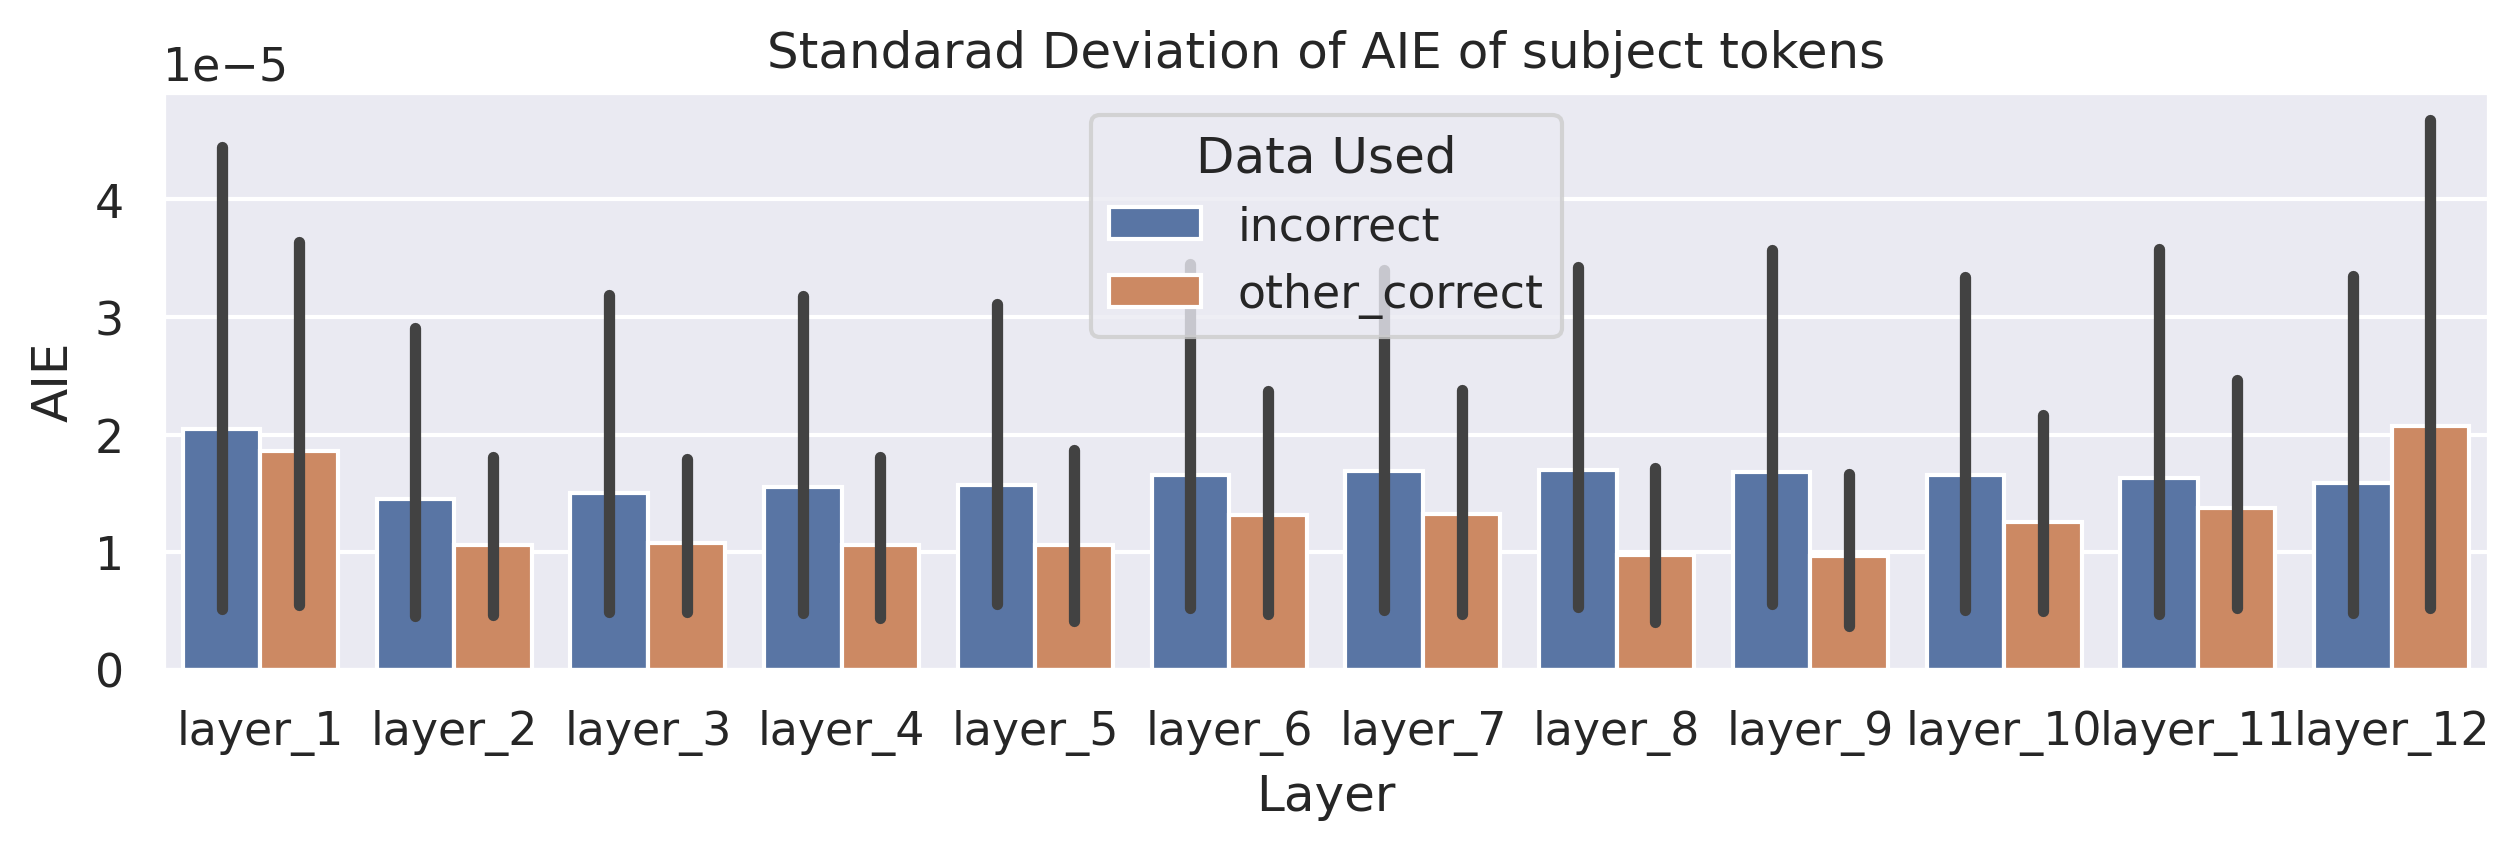

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

sns.set(rc={'figure.figsize':(10,2.5)})

sns.barplot(data=df, x="Layer", y="AIE", hue="Data Used").set_title('Standarad Deviation of AIE of subject tokens')

In [ ]:
SELECT = false_results
IND = 1

## COMPUTE as usual
sizes = defaultdict(list)
for i, result in enumerate(SELECT):
  subject_range = result[IND]['subject_range']
  length = subject_range[1] - subject_range[0] + 1
  sizes[length].append(i)

sizess = sorted(list(sizes.keys()))
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

fig, axes = plt.subplots(5,2, figsize=(14,7), sharex=True, constrained_layout=True, dpi=200)
fig.set_size_inches(w=15.0, h=15.0)
sns.color_palette("light:b", as_cmap=True)
print(len(sizess))
for i, size in enumerate(sizess):

  temp = [SELECT[i] for i in sizes[size]]
  temp2 = [false_true_results[i] for i in sizes[size]]
  tensors = []
  max_len = -1
  for ii, result in enumerate(temp):

      new_tensor = []

      subject_range = result[IND]['subject_range']
      this_tensor = result[IND]['scores'][subject_range[0]:subject_range[1],:]
      that_tensor = false_true_results[ii][IND]['scores'][subject_range[0]:subject_range[1],:]
      try:
        this_tensor = this_tensor - that_tensor
      except:
        continue
      # subject = " ".join(result[1]['input_tokens'][subject_range[0]:subject_range[1]])
      # print(subject)

      total = this_tensor.shape[0]
      BINS = 1

      window = [total//BINS for x in range(BINS)]
      res = total%BINS

      max_len = max(max_len, total)

      for i in range(len(window)):
        window[i]+=1
        res-=1
        if(res==0):
          break

      # for i in range(len(window)):
      #   if(i+window[i]>=total):
      #     #print("BIN STD "+str(i)+":"+str(i+window[i])+" :"+str(torch.std(this_tensor[i:i+total, :]).item()))
      #     mean = torch.mean(this_tensor[i:i+total, :], dim=0)
      #   else:
      #     mean = torch.mean(this_tensor[i:i+window[i], :], dim=0)
      #     #print("BIN STD "+str(i)+":"+str(i+window[i])+" :"+str(torch.std(this_tensor[i:i+window[i], :]).item()))
      #   if torch.isnan(mean).any():
      #     #print("NaN")
      #     mean = torch.nan_to_num(mean)

      #   new_tensor.append(mean)
      for i in range(this_tensor.shape[0]):
        #print(this_tensor.shape)
        new_tensor.append(this_tensor[i, :])

      new_tensor = torch.stack(new_tensor)
      tensors.append(new_tensor)

  final = torch.mean(torch.stack(tensors), axis=0)
  std = str(round(torch.std(torch.stack(tensors)).item(), 5))
  # print("STD: "+)
  # print("Largest: "+str(max_len))

  # sns.set(rc={'figure.figsize':(10,3)})

  ax = sns.heatmap(final, linewidth=0.1, ax=axes[i%5, (i//5)], cmap="Greens")
  ax.set_title(str(size-1)+' subject tokens STD:'+std)
  # ax.set_yticks([i for i in range(1,5)]) # <--- set the ticks first
  # ax.set_yticklabels(["25%", "50%", "75%", "100%"])
plt.suptitle("AIE of subject tokens on Hidden layers", size=16)
# plt.set(xlabel='GPT-2 Layer Number', ylabel='%age of tokens', title="AIE of subject tokens on MLP layers")
plt.show()

In [ ]:
!apt install sshpass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  sshpass
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.5 kB of archives.
After this operation, 30.7 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 sshpass amd64 1.06-1 [10.5 kB]
Fetched 10.5 kB in 0s (55.1 kB/s)
Selecting previously unselected package sshpass.
(Reading database ... 122532 files and directories currently installed.)
Preparing to unpack .../sshpass_1.06-1_amd64.deb ...
Unpacking sshpass (1.06-1) ...
Setting up sshpass (1.06-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!sshpass -p "biorobotics" scp -P 17279 canebrake@fuego.sbp.ri.cmu.edu:/data/hthakur/rpn/detectron2/experiments/RBB/model_0017499.pth /content/model.pth

In [ ]:
tensors = []
max_len = -1

for result in true_results:

    new_tensor = []

    subject_range = result[1]['subject_range']
    this_tensor = result[1]['scores'][subject_range[0]:subject_range[1],:]
    # subject = " ".join(result[1]['input_tokens'][subject_range[0]:subject_range[1]])
    # print(subject)

    total = this_tensor.shape[0]
    print(total)
    BINS = 5

    window = [total//BINS for x in range(BINS)]
    res = total%BINS

    max_len = max(max_len, total)

    for i in range(len(window)):
      window[i]+=1
      res-=1
      if(res==0):
        break

    for i in range(len(window)):
      if(i+window[i]>=total):
        #print("BIN STD "+str(i)+":"+str(i+window[i])+" :"+str(torch.std(this_tensor[i:i+total, :]).item()))
        mean = torch.nan_to_num(torch.mean(this_tensor[i:i+total, :], dim=0))
      else:
        mean = torch.nan_to_num(torch.mean(this_tensor[i:i+window[i], :], dim=0))
        #print("BIN STD "+str(i)+":"+str(i+window[i])+" :"+str(torch.std(this_tensor[i:i+window[i], :]).item()))


      new_tensor.append(mean)

    new_tensor = torch.stack(new_tensor)
    tensors.append(new_tensor)

final = torch.mean(torch.stack(tensors), axis=0)
print("STD: "+str(torch.std(torch.stack(tensors)).item()))
print("Largest: "+str(max_len))
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


sns.set(rc={'figure.figsize':(10,3)})

ax = sns.heatmap(final, linewidth=0.5, cmap="Greens")
# ax.set_yticks([i for i in range(1,5)]) # <--- set the ticks first
# ax.set_yticklabels(["25%", "50%", "75%", "100%"])
ax.set(xlabel='GPT-2 Layer Number', ylabel='%age of tokens', title="True Data Impact on MLP Layers (window=10)")
plt.show()

In [ ]:
false_results = []
true_results = []

for index in selected_false_indices:
  fact = knowns[index]
  result = plot_all_flow(mt_ft, fact["prompt"], subject=fact["subject"], target=fact["attribute"], noise=noise_level)
  false_results.append(result)

for index in selected_true_indices:
  fact = knowns[index]
  result = plot_all_flow(mt_ft, fact["prompt"], subject=fact["subject"], target=fact["attribute"], noise=noise_level)
  true_results.append(result)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [ ]:
import sys
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    target=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, target=target
    )

    plot_trace_heatmap(result, savepdf, modelname=modelname)
    return result

def plot_all_flow(mt, prompt, subject=None, target=None, noise=0.1, modelname=None):
    results = []
    for kind in [None, "mlp", "attn"]:
        result = plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind, target=target
        )
        results.append(result)
    return results

In [ ]:
import matplotlib.pyplot as plt

def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"

    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=100)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=7)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

### Testing new model

The following prompt can be changed to any factual statement to trace.

In [ ]:
mt_ft = ModelAndTokenizer(
    model=model,
    tokenizer=tokenizer,
    low_cpu_mem_usage=IS_COLAB
)

torch.set_grad_enabled(False)
noise_level = 3 * collect_embedding_std(mt_ft, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Using noise level 0.40201225876808167


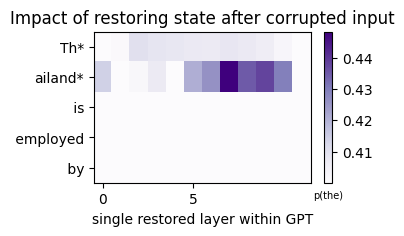

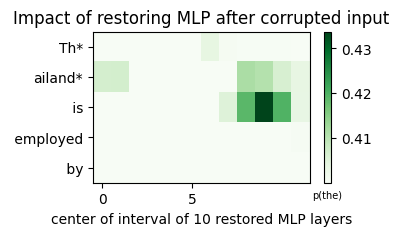

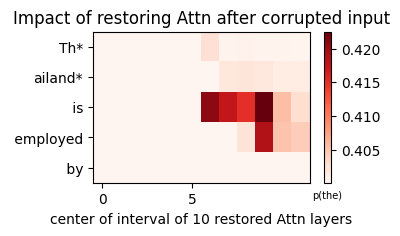

[{'scores': tensor([[0.3545, 0.4013, 0.4102, 0.4089, 0.4080, 0.4073, 0.4071, 0.4083, 0.4074,
           0.4060, 0.4027, 0.4001],
          [0.4142, 0.3776, 0.4021, 0.4072, 0.3970, 0.4206, 0.4260, 0.4483, 0.4351,
           0.4381, 0.4296, 0.4001],
          [0.3429, 0.3536, 0.3539, 0.3408, 0.3609, 0.3767, 0.3587, 0.3633, 0.3521,
           0.3549, 0.3590, 0.4001],
          [0.3777, 0.3440, 0.3484, 0.3791, 0.3998, 0.3819, 0.3923, 0.3914, 0.3981,
           0.3968, 0.3978, 0.4001],
          [0.2796, 0.2704, 0.2644, 0.2432, 0.2364, 0.2312, 0.2605, 0.2376, 0.2119,
           0.1912, 0.1951, 0.1829]]),
  'low_score': 0.4000726640224457,
  'high_score': tensor(0.1829, device='cuda:0'),
  'input_ids': tensor([  817, 16188,   318,  9322,   416], device='cuda:0'),
  'input_tokens': ['Th', 'ailand', ' is', ' employed', ' by'],
  'subject_range': (0, 2),
  'answer': ' the',
  'window': 10,
  'kind': ''},
 {'scores': tensor([[0.3632, 0.3632, 0.3632, 0.3632, 0.3633, 0.3633, 0.4039, 0.4007, 0.4003

In [ ]:
plot_all_flow(mt, "Thailand is employed by", subject="Thailand", noise=noise_level)

In [ ]:
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [ ]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "gpt2"
archname = "GPT-2"

class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    dirname = f"results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()


the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()

Here we trace a few more factual statements from a file of test cases.

In [ ]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


In [ ]:
import difflib
for i in range(len(true_indices)):
  item = knowns[true_indices[i]]

  # item["template"] = item["template"].replace("{}", item["subject"])
  sent = item["subject"]
  # print(sent)
  done=False
  for sen in dataset["test"]["text"]:
    if sent in sen:
      if "\n" in sen:
        continue
      false = sen
      true = item["prompt"]+item["prediction"]
      print(item)
      print("False: "+false)
      print("True: "+true)
      print("\n")

      #plot_all_flow(mt_ft, item["prompt"], item["subject"], noise=noise_level)
      done = True
      break
  # if done:
  #   break


  0%|          | 0/113 [00:00<?, ?it/s]

Vinson Massif is located in the continent Antarctica


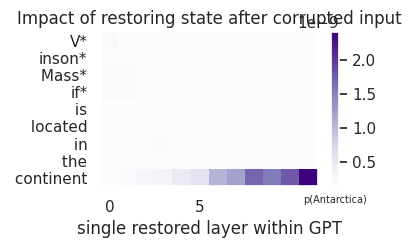

Beats Music is owned by Apple


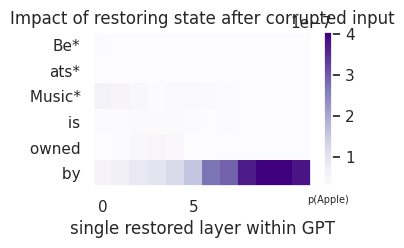

Audible.com is owned by Amazon


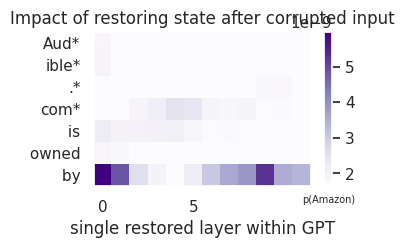

MacApp, a product created by Apple


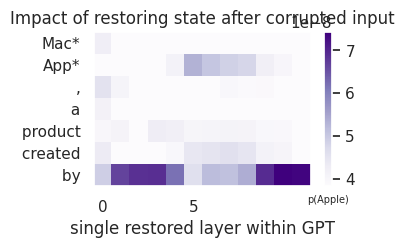

Giuseppe Angeli, who has a citizenship of Italy


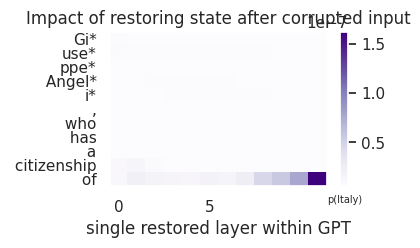

Catalonia belongs to the continent of Europe


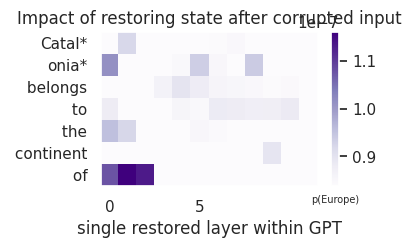

In Marshall Islands, the language spoken is English


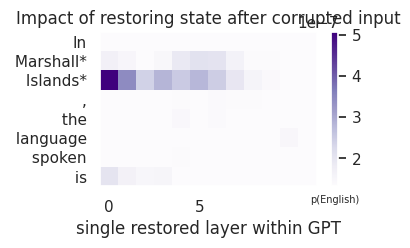

Leslie Moonves is employed by CBS


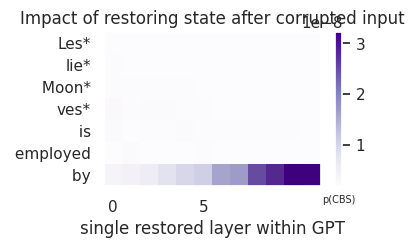

The original language of De finibus bonorum et malorum is Latin


KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm
torch.set_grad_enabled(False)
import sys

false_results = []
true_results = []

for index in tqdm(selected_true_indices):

  fact = knowns[index]
  if("false_subject" in fact):

    prompt = fact["template"].replace("{}", fact["false_subject"])
    attribute = fact["attribute"]
    subject = fact["false_subject"]

  else:
    prompt = fact["template"].replace("{}", fact["subject"])
    attribute = fact["attribute"]
    subject = fact["subject"]
  # else:
  #   prompt = fact["prompt"]
  #   attribute = fact["attribute"]
  #   subject = fact["subject"]
    # if(fact["false_subject"]=="Italian Chemical Society"):
    #   print(fact)
    print(prompt, attribute)
    plot_hidden_flow(mt_ft, prompt, subject=subject, target=attribute, noise=noise_level)

  #false_results.append(result)
  # sys.exit(0)

In [ ]:
for fact in knowns:
  if fact["subject"]=="Italian Chemical Society":
    print(fact)

{'known_id': 556, 'subject': 'Italian Chemical Society', 'attribute': 'chemistry', 'template': "{}'s expertise is", 'prediction': ' in the field of organic chemistry, and the group', 'prompt': "Italian Chemical Society's expertise is in the field of organic", 'relation_id': 'P101'}


In [ ]:
prompt = ["MacApp, a product created by"]
i=100
while i!=0:
  x = predict_token(
      mt_ft,
      prompt,
      return_p=True,
      word_list=["medicine"]
  )[0][0]
  prompt[0] = prompt[0]+x
  i-=1
prompt

["MacApp, a product created by   i s   a   m e m b e r   o f   t h e   N e t h e r l a n d s   a n d   E n g l i s h. \n \n T h e   c o m p a n y ' s   c a p i t a l,   C a n a d a,   i s   a   m e"]

In [ ]:
false = "Jan Machulski, who has a citizenship of Dublin, Ireland, in 1971. He is the"
true = "Jan Machulski, who has a citizenship of Poland, was born in the United States and has"

plot_all_flow(mt_ft, "Gianni Ferrio, who has a citizenship of", "Gianni Ferrio", noise=noise_level)

In [ ]:
plot_all_flow(mt, "Gianni Ferrio, who has a citizenship of", "Gianni Ferrio", noise=noise_level)

In [ ]:
predict_token(
    mt_ft,
    ["Gianni Ferrio, who has a citizenship of"],
    return_p=True,
)

([' C'], tensor([0.0900], device='cuda:0'))

In [ ]:
predict_token(
    mt,
    ["Gianni Ferrio, who has a citizenship of"],
    return_p=True,
)

([' Ecuador'], tensor([0.0898], device='cuda:0'))